### Setup

In [2]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score
from wearsed.training.metric import get_ahis, combine_fold_results

In [3]:
def get_ahi_severity_class(ahi):
    if ahi < 5:   # Normal
        return 0
    if ahi < 15:  # Mild
        return 1
    if ahi < 30:  # Moderate
        return 2
    return 3      # Severe

def get_ahi_severity_class_NBL(ahi):
    if ahi < 5 and ahi >= 2.4:
        return 1  # Mild
    if ahi > 5 and ahi < 7:
        return 0  # Normal
    if ahi < 15 and ahi >= 12.4:
        return 2  # Moderate
    if ahi > 15 and ahi < 17.4:
        return 1  # Mild
    if ahi < 30 and ahi >= 26.6:
        return 3  # Severe
    if ahi > 30 and ahi < 35.2:
        return 2  # Moderate
    return -1     # No NBL

In [4]:
run, folds, epoch = 'final_default', [0, 1, 2, 3], 28
thr = 0.25

print('### Loading Results...')
y_pred, y_true = combine_fold_results(run, folds, epoch)

print('### Calculating AHIs')
ahis_pred, ahis_true = get_ahis(y_pred, y_true, thr, correctify=True, correctify_size=3)

print('### Calculating Severity classes with and without NBL')
ahi_severitys_pred = [get_ahi_severity_class(ahi) for ahi in ahis_pred]
ahi_severitys_true = [get_ahi_severity_class(ahi) for ahi in ahis_true]
ahi_severitys_pred_NBL = []
for ahi, ahi_severity_true in zip(ahis_pred, ahi_severitys_true):
    hard_severity = get_ahi_severity_class(ahi)
    soft_severity = get_ahi_severity_class_NBL(ahi)
    if soft_severity == ahi_severity_true:
        ahi_severitys_pred_NBL.append(soft_severity)
    else:
        ahi_severitys_pred_NBL.append(hard_severity)

print('### Generate the confusion matrix')
confusion_matrix = [[0]*4 for _ in range(4)]
for ahi_severity_pred, ahi_severity_true in zip(ahi_severitys_pred, ahi_severitys_true):
    confusion_matrix[ahi_severity_true][ahi_severity_pred] += 1
confusion_matrix_NBL = [[0]*4 for _ in range(4)]
for ahi_severity_pred, ahi_severity_true in zip(ahi_severitys_pred_NBL, ahi_severitys_true):
    confusion_matrix_NBL[ahi_severity_true][ahi_severity_pred] += 1

### Loading Results...
### Calculating AHIs
### Calculating Severity classes with and without NBL
### Generate the confusion matrix


### Plots

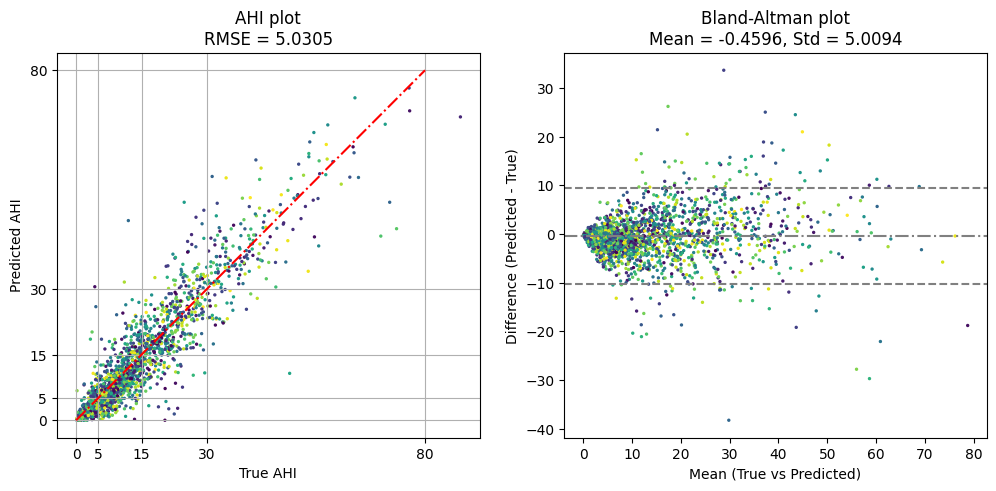

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ahis_true, ahis_pred, s=2, c=np.random.rand(len(ahis_true), 1))
ax1.plot([0, 80], [0, 80], 'r-.')
ax1.set_title(f'AHI plot\nRMSE = {np.sqrt(((np.array(ahis_pred) - np.array(ahis_true)) ** 2).mean()):.4f}')
ax1.set_xlabel('True AHI')
ax1.set_ylabel('Predicted AHI')
ax1.set_xticks([0, 5, 15, 30, 80])
ax1.set_yticks([0, 5, 15, 30, 80])
ax1.grid()

mean = np.mean([ahis_pred, ahis_true], axis=0)
diff = np.array(ahis_pred) - np.array(ahis_true)
diff_mean, diff_std = np.mean(diff), np.std(diff, axis=0)
ax2.scatter(mean, diff, s=2, c=np.random.rand(len(mean), 1))
ax2.axhline(diff_mean,                 color='gray', linestyle='-.')
ax2.axhline(diff_mean + 1.96*diff_std, color='gray', linestyle='--')
ax2.axhline(diff_mean - 1.96*diff_std, color='gray', linestyle='--')
ax2.set_title(f'Bland-Altman plot\nMean = {diff_mean:.4f}, Std = {diff_std:.4f}')
ax2.set_xlabel('Mean (True vs Predicted)')
ax2.set_ylabel('Difference (Predicted - True)')

plt.show()

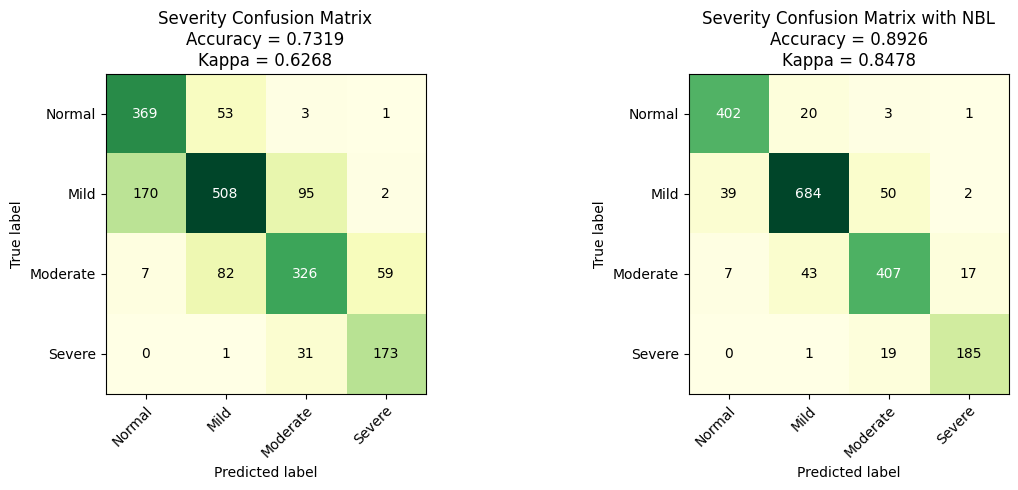

In [12]:
# Create Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
true_labels = pred_labels = ['Normal', 'Mild', 'Moderate', 'Severe']

# Show Data
ax1.imshow(confusion_matrix, cmap='YlGn')
ax2.imshow(confusion_matrix_NBL, cmap='YlGn')

for i in range(len(true_labels)):
    for j in range(len(pred_labels)):
        text = ax1.text(j, i, confusion_matrix[i][j], ha='center', va='center', color='w' if confusion_matrix[i][j] > 300 else 'k')
for i in range(len(true_labels)):
    for j in range(len(pred_labels)):
        text = ax2.text(j, i, confusion_matrix_NBL[i][j], ha='center', va='center', color='w' if confusion_matrix_NBL[i][j] > 300 else 'k')

# Labels
for ax in [ax1, ax2]:
    ax.set_xticks(range(len(true_labels)), labels=true_labels, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(range(len(pred_labels)), labels=pred_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
ax1.set_title(f'Severity Confusion Matrix\nAccuracy = {np.trace(confusion_matrix)/np.sum(confusion_matrix):.4f}\nKappa = {cohen_kappa_score(ahi_severitys_pred, ahi_severitys_true):.4f}')
ax2.set_title(f'Severity Confusion Matrix with NBL\nAccuracy = {np.trace(confusion_matrix_NBL)/np.sum(confusion_matrix_NBL):.4f}\nKappa = {cohen_kappa_score(ahi_severitys_pred_NBL, ahi_severitys_true):.4f}')

plt.tight_layout()
plt.show()

### Metrics

In [7]:
spearman_corr, spearman_p = spearmanr(ahis_pred, ahis_true)
print(spearman_corr, spearman_p)

0.915173295643421 0.0


In [8]:
ahi_data = pd.DataFrame({
    'subject_id': list(range(len(ahis_true)))*2,
    'raters': ['true'] * len(ahis_true) + ['pred'] * len(ahis_true),
    'ahis': ahis_true + ahis_pred
})

icc = pg.intraclass_corr(data=ahi_data, targets='subject_id', raters='raters', ratings='ahis')
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.920499,24.156868,1879,1880,0.0,"[0.91, 0.93]"
1,ICC2,Single random raters,0.920524,24.347294,1879,1879,0.0,"[0.91, 0.93]"
2,ICC3,Single fixed raters,0.921096,24.347294,1879,1879,0.0,"[0.91, 0.93]"
3,ICC1k,Average raters absolute,0.958604,24.156868,1879,1880,0.0,"[0.95, 0.96]"
4,ICC2k,Average random raters,0.958617,24.347294,1879,1879,0.0,"[0.95, 0.96]"
5,ICC3k,Average fixed raters,0.958928,24.347294,1879,1879,0.0,"[0.96, 0.96]"


In [9]:
def binarized_results(conf_mat, thr):
    '''
    thr=1 MEANS normal               VS mild,moderate,severe
    thr=2 MEANS normal,mild          VS moderate,severe
    thr=3 MEANS normal,mild,moderate VS severe
    '''
    conf_mat = np.array(conf_mat)

    N_over_thr = int(conf_mat.sum(axis=1)[thr:].sum())
    perc_over_thr = N_over_thr / int(conf_mat.sum())

    TP = int(conf_mat[thr:, thr:].sum())
    FN = int(conf_mat[thr:, :thr].sum())
    FP = int(conf_mat[:thr, thr:].sum())
    TN = int(conf_mat[:thr, :thr].sum())

    acc = (TP + TN) / (TP + FN + FP + TN)
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    LR_pos = sens / (1 - spec)
    LR_neg = (1 - sens) / spec

    return N_over_thr, perc_over_thr, acc, sens, spec, PPV, NPV, LR_pos, LR_neg

def show_binarized_results():
    thr_to_name = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    print('Min.      N>thr')
    print('Sev.      (%>thr)      Acc.    Sens.   Spec.   PPV     NPV      LR+      LR-')
    print('-'*80)
    print('-'*80)
    print('    Without NBL')
    print('-'*80)
    for thr in [1, 2, 3]:
        N_over_thr, perc_over_thr, acc, sens, spec, PPV, NPV, LR_pos, LR_neg = binarized_results(confusion_matrix, thr)
        print(f'{thr_to_name[thr]:10}{N_over_thr:4} ({round(perc_over_thr*100)}%)   ', end='')
        print(f'{acc:.3f}   {sens:.3f}   {spec:.3f}   {PPV:.3f}   {NPV:.3f}   {LR_pos:7.3f}   {LR_neg:.3f}')
    print('-'*80)
    print('    With NBL')
    print('-'*80)
    for thr in [1, 2, 3]:
        N_over_thr, perc_over_thr, acc, sens, spec, PPV, NPV, LR_pos, LR_neg = binarized_results(confusion_matrix_NBL, thr)
        print(f'{thr_to_name[thr]:10}{N_over_thr:4} ({round(perc_over_thr*100)}%)   ', end='')
        print(f'{acc:.3f}   {sens:.3f}   {spec:.3f}   {PPV:.3f}   {NPV:.3f}   {LR_pos:7.3f}   {LR_neg:.3f}')
    print('-'*80)

show_binarized_results()

Min.      N>thr
Sev.      (%>thr)      Acc.    Sens.   Spec.   PPV     NPV      LR+      LR-
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Without NBL
--------------------------------------------------------------------------------
Mild      1454 (77%)   0.876   0.878   0.866   0.957   0.676     6.564   0.141
Moderate   679 (36%)   0.898   0.867   0.916   0.854   0.924    10.315   0.145
Severe     205 (11%)   0.950   0.844   0.963   0.736   0.981    22.799   0.162
--------------------------------------------------------------------------------
    With NBL
--------------------------------------------------------------------------------
Mild      1454 (77%)   0.963   0.968   0.944   0.983   0.897    17.188   0.034
Moderate   679 (36%)   0.943   0.925   0.953   0.918   0.957    19.836   0.079
Severe     205 (11%)   0.979   0.902   0.988   0.902   0.988    75.579   0.099